In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math

In [2]:
! wget -o - "http://mcb112.org/w07/w07-data.tbl"

--2018-10-29 11:48:42--  http://mcb112.org/w07/w07-data.tbl
Resolving mcb112.org... 96.126.110.11, 2600:3c03::f03c:91ff:fec8:383c
Connecting to mcb112.org|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1050 (1.0K)
Saving to: 'w07-data.tbl.2'

     0K .                                                     100% 52.7M=0s

2018-10-29 11:48:44 (52.7 MB/s) - 'w07-data.tbl.2' saved [1050/1050]



In this problem, I am given a set of RNA-seq data which contains expression data from genes which have oscillating expression patterns. Thus, my goal is to find the oscillating regression which best captures. I used the following trigonometric identity to enable me to model an oscillating in a linear form:

$yt=p0+p1sin(2πωt)+p2cos(2πωt)$

Then, using maximum likelihood calculations, I found the optimal parameters $p0, p1$, and $p2$ for each gene.

The "Moriarty" method described refers to another method of finding the optimal regression which fails in this scenario because of an implicit assumption of constant variance for all data points.

In [4]:
table = pd.read_table('w07-data.tbl', delim_whitespace = True)
table = table.drop(['------------'])
table2 = np.array(table)
for i in range(len(table2[0])):
    hello = ''.join(c for c in table2[0][i] if c.isalnum()) 
    table2[0][i] = hello
table2 = np.insert(table2, 0, np.array(('4', '4', '8', '8', '16', '16', '24', '24')), 0)
table2 = table2.astype(float)
times = table2[0]
stdvs = table2[1]
data = table2[2:]

Next, I define a function that calculates the nll of data given a certain model.

In [5]:
def nll (params, levels, times, stdvs):
    ll = 0
    w = 1/24
    for i in range(len(levels)) :
        curr_mu = params[0] + params[1]*math.sin(2*math.pi*w*times[i]) + params[2]*math.cos(2*math.pi*w*times[i])
        curr_stdv = stdvs[i]
        residual = levels[i] - curr_mu
        ll += stats.norm.logpdf(residual, 0, curr_stdv)
    return -ll

In [6]:
#Setting my initial guess to 1.0, 1.0, 1.0.
p0 = np.array([1.0, 1.0, 1.0])

Finally, using the scipy.optimize.minimize function, I find the parameters p0, p1, and p2, which minimize the negative log likelihood of each gene (thereby finding the parameters that maximize the total likelihood). Note that because the parameters I solve for are simply coefficients of different terms, it is ok for them to be positive or negative so I don't need to place bounds on them.

In [7]:
results = []
nlls = []
for j in range(len(data)):
    result = (optimize.minimize(nll, p0, (data[j], times, stdvs)))
    nlls.append(result.fun)
    results.append(result.x)

Next, I use the the parameters I calculated in the previous step to solve for our optimal b, a, and phi values. To make the results more interpretable and comparable to Moriarty's data, I ensure that the a and phi values are non-negative by performing operations to them which don't actually change their significance (as shown in the sample code on the website) but which ensure that they are positive values.

In [8]:
final = []
w = 1/24
for k in range(len(results)):
    phi = math.atan(results[k][2]/results[k][1])/(2*math.pi*w)
    a = results[k][1]/math.cos(2*math.pi*w*phi)
    if a < 0:
        a = -a
        phi = phi + 12
    if phi < 0:
        phi = phi + 24
    final.append([results[k][0], a, phi])

Below, I show my final parameters, b, a, and phase (phi), that maximize the likelihood of the model. 

In [9]:
output = pd.DataFrame(final, columns = ['b(tpm)', 'a(tpm)', 'phase(hr)'])
output = output.set_index(table.index[1:])
output

,b(tpm),a(tpm),phase(hr)
anise,46.877693,25.164186,2.222913
kiwi,44.162622,28.429277,15.938287
carrot,39.648484,23.138408,3.904267
grape,46.542108,23.487015,13.867981
tangerine,42.668035,24.294438,9.696871
melon,40.100006,25.140899,5.451114
clementine,42.998520,30.307667,18.434851
spinach,49.113596,18.120154,0.018882
beet,43.517723,21.330611,11.860552
huckleberry,48.020655,25.446541,21.828315


In [10]:
!python ./moriarty.py w07-data.tbl > 'moriarty_results.tbl'

./moriarty.py:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result    = np.linalg.lstsq(A, Y[g])[0]


Here, I get the values of b, a, and phi for each gene that Moriarty generated in his model.

In [11]:
with open('moriarty_results.tbl', 'r') as f:
    next(f)
    next(f)
    values = []
    for line in f:
        values.append(line.split()[1:])
    values = np.array(values)
    values = values.astype(float)
f.close()

Next, I find the nll for each gene using Moriarty's parameters, and sum to find the total log likelihood for Moriarty's model and my model. Then I check to see how they compare by subtracting the log likelihoods, exponentiating, then taking the log of this to find how many orders of magnitude apart our likelihoods are. 

In [13]:
adjusted = []
for i in range(len(values)):
    p0 = values[i][0]
    p1 = values[i][1]*math.cos(2*math.pi*w*values[i][2])
    p2 = values[i][1]*math.sin(2*math.pi*w*values[i][2])
    adjusted.append([p0, p1, p2])

moriarty_nlls = []
for k in range(len(adjusted)):
    m_nll = nll(adjusted[k], data[k], times, stdvs)
    moriarty_nlls.append(m_nll)
how_much_better = np.log10(np.exp(sum(moriarty_nlls)-sum(nlls)))
print("The sum of my negative log likelihoods for all genes is %.1f (corresponding to a total log likelihood of %.1f)."%(sum(nlls), -sum(nlls)))
print("The sum of Moriarty's negative log likelihoods is %.1f (corresponding to a total log likelihood of %.1f)."%(sum(moriarty_nlls), -sum(moriarty_nlls)))
print("My estimate is %i orders of magnitude better than Moriarty's estimate."%(how_much_better))

The sum of my negative log likelihoods for all genes is 310.5 (corresponding to a total log likelihood of -310.5).
The sum of Moriarty's negative log likelihoods is 455.3 (corresponding to a total log likelihood of -455.3).
My estimate is 62 orders of magnitude better than Moriarty's estimate.


As shown above, the optimal parameters for the 12 genes I achieved are much more likely than those that Moriarty calculated. Likely, the reason behind this huge difference is that, although Moriarty's trigonometric trick is correct, in his calculation for the parameters, Moriarty uses a regular least squares fit. One of the assumptions underlying this caclulation is that the residuals of the data are normally distributed around the regression (following a single distribution). However, we know that in this case, while we can imagine that the residual of each individual data point is normally distributed, each data point has a different standard deviation, meaning that applying a single distribution to all residuals would be a huge mistake. Imagine, for example, that we applied a least squares fit to a set of two example points - one with a standard deviation of 2 and one with a standard deviation of 20. Assuming that the residuals of these point were normally distributed about my regression according to the same distribution would not make sense, because the data point with standard deviation of 2 should clearly be 'weighted' more in order to maximize the likelihood of the model. In the next question, we show through visualizations some of the effects of our differing models. 

Below, I plot the data, my model, and Moriarty's model for all 12 genes. 

In [14]:
def find_prediction(times, params):
    predictions = []
    for time in times:
        prediction = params[0]+params[1]*math.sin(2*w*math.pi*(time + params[2]))
        predictions.append(prediction)
    return predictions

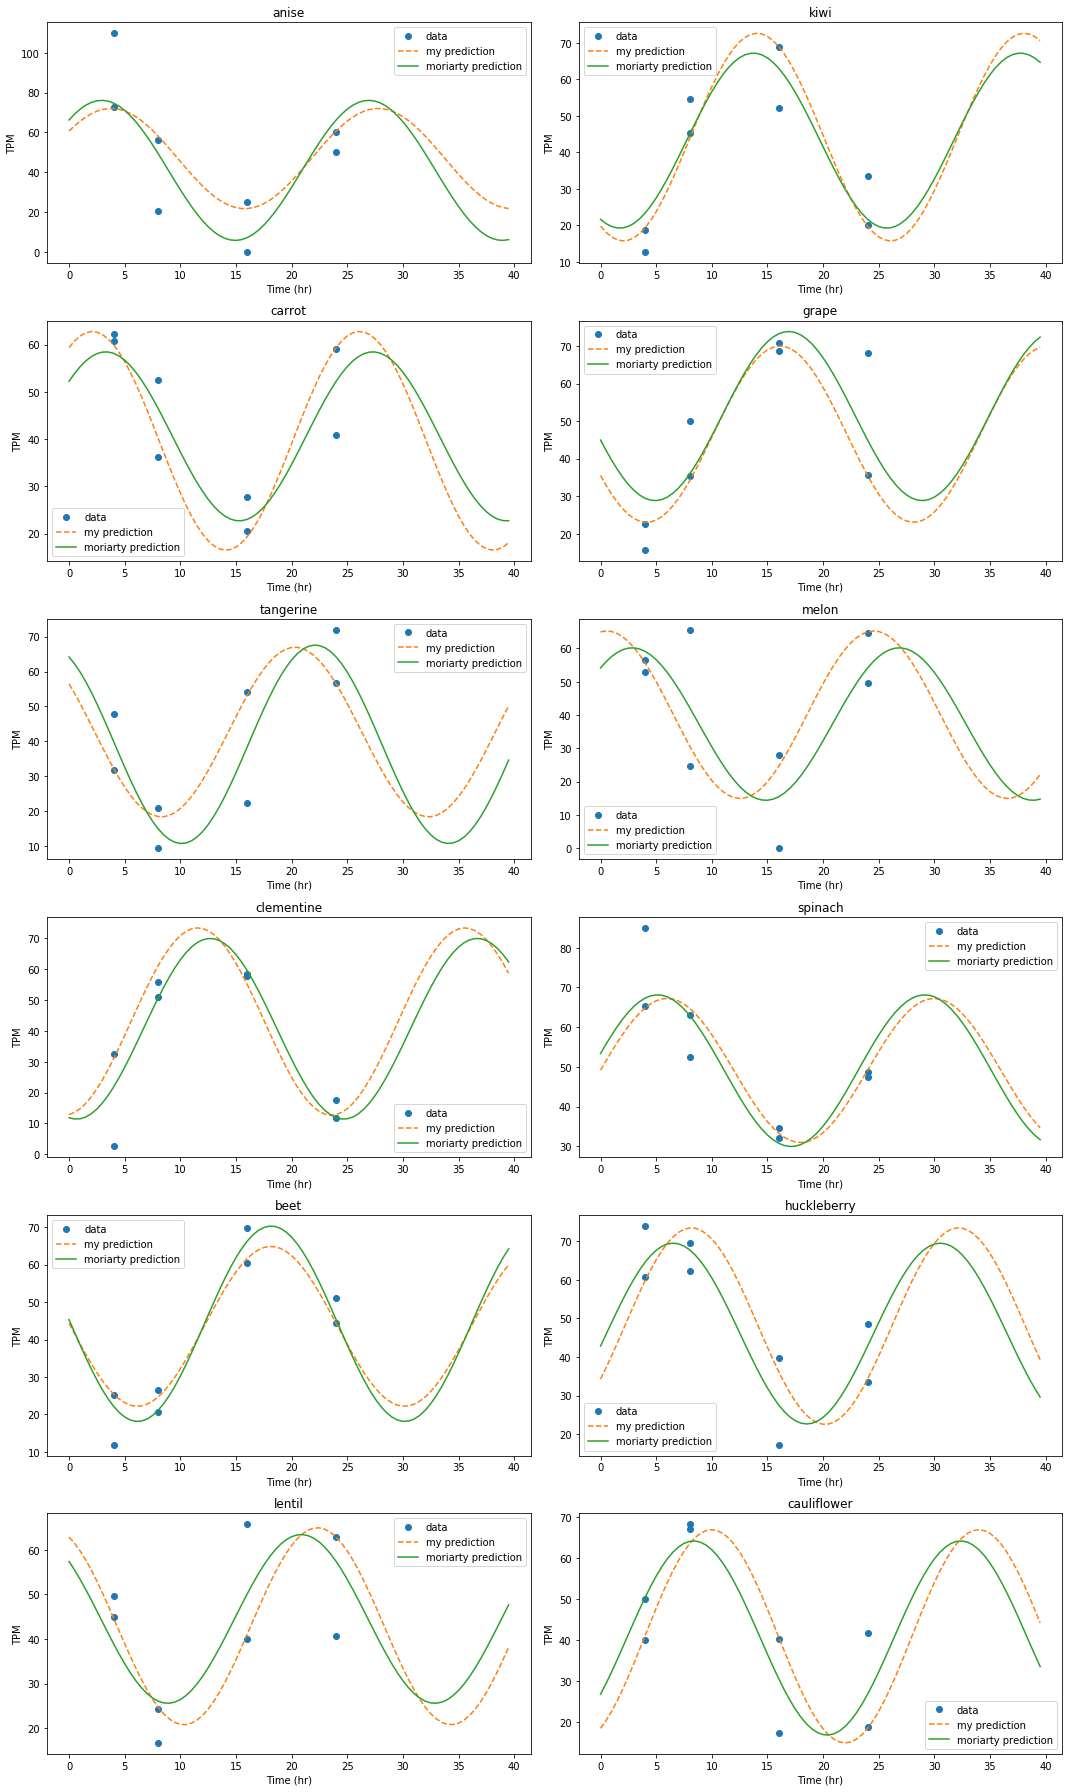

In [15]:
fig = plt.subplots(figsize= (15, 25))
for i in range(len(final)):
    x = np.arange(0, 40, 0.5)
    y_me = find_prediction(x, final[i])
    y_mor = find_prediction(x, values[i])
    plt.subplot(6, 2, i+1)
    plt.plot(times, data[i], 'o', label = 'data')
    
    plt.plot(x, y_me, '--', label = 'my prediction')
    plt.plot(x, y_mor, '-', label = 'moriarty prediction')
    plt.xlabel('Time (hr)')
    plt.ylabel('TPM')
    plt.legend(loc='best')
    plt.title(table.index[i+1])
    plt.tight_layout()

These graphs are interesting, although it is hard to interpret them simply by eye to find significance between how my model and how Moriarty's model perform, and what consequences these differences have. One way to help visualize this is to include error bars in our graphs. Moreover, it would be helpful to see the error bars differentiated based on the standard deviation in order to more clearly see which points have the highest standard deviation, and what effect they seem to be having on each model. As discussed above, if my idea is correct, we should see that Moriarty's model looks like it is equally 'pulled' by data points regardless of standard deviation, while in my model, we should see that the data points with standard deviation of 20, if far apart from a data point with smaller standard deviation, should not effect my regression as much as the one with low s.d. Below, I plot the same graphs, but including error bars (the error bars corresponding to s.d. of 20 are one color, and those of 2 or 5 are the other).

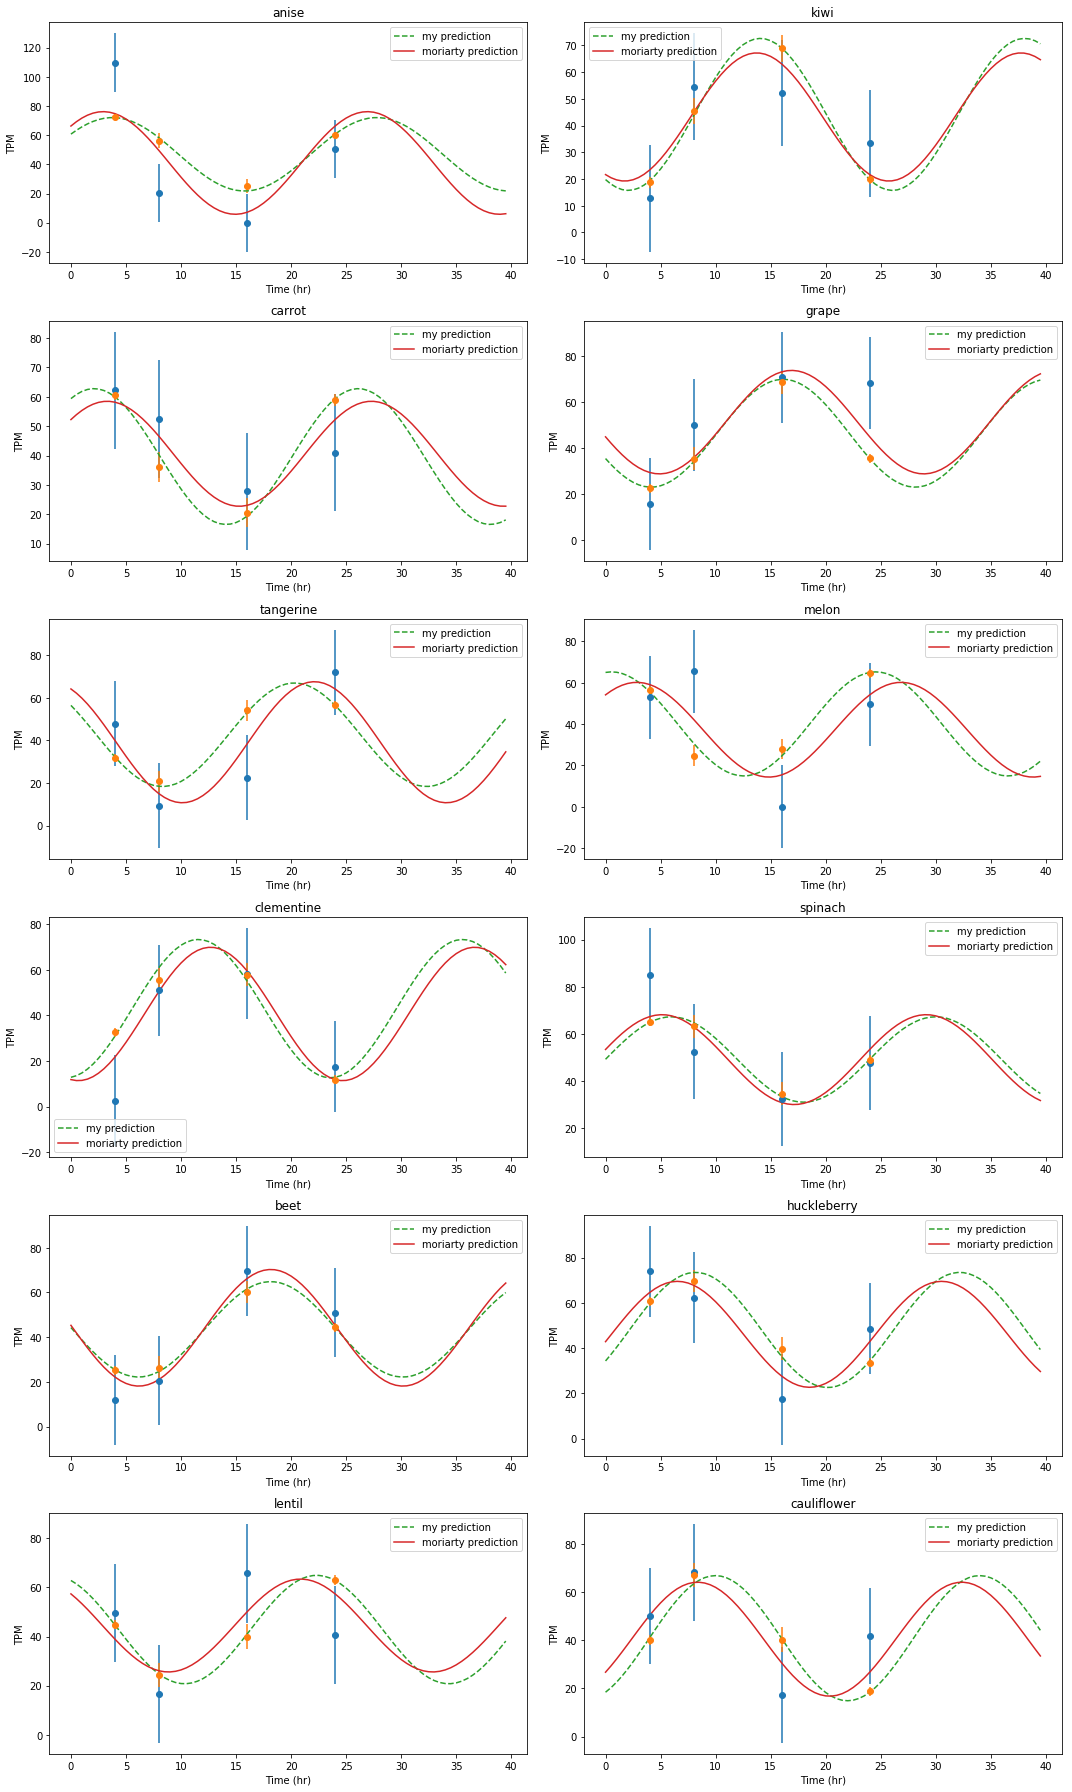

In [16]:
tpoints = [4, 8, 16, 24]
fig = plt.subplots(figsize= (15, 25))

for i in range(len(final)):
    x = np.arange(0, 40, 0.5)
    y_me = find_prediction(x, final[i])
    y_mor = find_prediction(x, values[i])
    plt.subplot(6, 2, i+1)

    #plt.plot(times, data[i], 'o', label = 'data')
    
    st1 = []
    st2 = []
    data1 = []
    data2 = []
    st1.append([stdvs[0], stdvs[2], stdvs[5], stdvs[7]])
    st2.append([stdvs[1], stdvs[3], stdvs[4], stdvs[6]])
    data1.append([data[i][0], data[i][2], data[i][5], data[i][7]])
    data2.append([data[i][1], data[i][3], data[i][4], data[i][6]])
    
    data1 = data1[0]
    data2 = data2[0]
    st1 = st1[0]
    st2 = st2[0]
    plt.errorbar(tpoints, data1, st1, fmt='o')
    plt.errorbar(tpoints, data2, st2, fmt='o')
    
    plt.plot(x, y_me, '--', label = 'my prediction')
    plt.plot(x, y_mor, '-', label = 'moriarty prediction')
    plt.xlabel('Time (hr)')
    plt.ylabel('TPM')
    plt.legend(loc='best')
    plt.title(table.index[i+1])
    plt.tight_layout()

Indeed, our prediction seems to be correct. For example, consider the data and regressions at the 16 hr timepoint for the tangerine graph. While Moriarty's prediction passes nearly through the midpoint of the two data points, regardless of the differing standard deviations, my model hugs much closer to the point with the smaller standard deviation. At this point, we can visually see the consequences of Moriarty's assumption that the residuals follow the same distribution, as discussed in question 2. Moreover, the effect is not just seen at this one timepoint - checking all the other data points for all 12 genes shows a similar pattern. 

It would be interesting to see what different biological conclusions our models come to. The phi values that Moriarty comes to leads him to believe one particular order of the pathway of the sand mouse circadian oscillator. Below, I order my genes ordered by phi, showing what order my conclusions come to for the circadian oscillator. I then do the same for Moriarty's data.

In [17]:
#My order
output.sort_values('phase(hr)', ascending=False)

,b(tpm),a(tpm),phase(hr)
huckleberry,48.020655,25.446541,21.828315
cauliflower,40.855999,25.993011,20.018050
clementine,42.998520,30.307667,18.434851
kiwi,44.162622,28.429277,15.938287
grape,46.542108,23.487015,13.867981
beet,43.517723,21.330611,11.860552
tangerine,42.668035,24.294438,9.696871
lentil,42.853389,22.068071,7.679799
melon,40.100006,25.140899,5.451114
carrot,39.648484,23.138408,3.904267


In [18]:
#Moriarty's order
moriarty = pd.DataFrame(values, columns = ['b(tpm)', 'a(tpm)', 'phase(hr)'])
moriarty = moriarty.set_index(table.index[1:])
moriarty.sort_values('phase(hr)', ascending=False)

,b(tpm),a(tpm),phase(hr)
huckleberry,46.09,23.42,23.47
cauliflower,40.44,23.67,21.64
clementine,40.66,29.24,17.32
kiwi,43.20,23.97,16.27
grape,51.37,22.54,13.10
beet,44.21,26.08,11.84
lentil,44.49,18.91,9.14
tangerine,39.15,28.42,7.89
melon,37.29,22.89,3.16
anise,40.93,35.17,3.07


As shown in the tables above, the two different models come to different conclusions about the order of the circadian oscillator pathway. For example, my regression comes to the conclusion that tangerine comes before lentil, and that carrot comes before anise - Moriarty's work comes to the opposite conclusion, but as we established, my values are much more likely to be true. These different orders suggest drastically different ideas about how the pathway operates. Thus, plotting these orders side by side shows how the wrong assumptions underlying Moriarty's regression can lead to far-reaching consequences in biological understanding.